In [9]:
# Import packages
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
import json

In [28]:
# Load the business.json file
with open("C:\\Users\\Raymond Loh\\OneDrive\\Documents\\yelp_academic_dataset_business.json", encoding="utf-8") as dataset_business:
    data = [json.loads(line) for line in dataset_business]
# Create DataFrame from the loaded data
df_b = pd.DataFrame(data)

In [27]:
# Show the DataFrame's structure
print(df_b.info())

<class 'pandas.core.frame.DataFrame'>
Index: 119698 entries, 1 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   119698 non-null  object 
 1   name          119698 non-null  object 
 2   address       119698 non-null  object 
 3   city          119698 non-null  object 
 4   state         119698 non-null  object 
 5   postal_code   119698 non-null  object 
 6   latitude      119698 non-null  float64
 7   longitude     119698 non-null  float64
 8   stars         119698 non-null  float64
 9   review_count  119698 non-null  int64  
 10  is_open       119698 non-null  int64  
 11  attributes    107350 non-null  object 
 12  categories    119603 non-null  object 
 13  hours         103603 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 13.7+ MB
None


In [13]:
# Filter the DataFrame to include only businesses that are still open
df_b = df_b[df_b['is_open'] == 1]
# Split the categories and explode them into separate rows, then filter for coffee-related categories
df_explode = df_b.assign(categories=df_b.categories.str.split(', ')).explode('categories')
coffee_categories = df_explode[df_explode.categories.str.contains('Coffee', case=True, na=False)]
# Count the occurrences of coffee-related categories
coffee_category_counts = coffee_categories.categories.value_counts()
# Further filter the original DataFrame for specific coffee-related business categories
business_coffee = df_b[df_b['categories'].str.contains(
    'Coffee & Tea|Coffee Roasteries|Coffeeshops|Coffee & Tea Supplies',
    case=False, na=False)]
# Display results
print(coffee_category_counts)

categories
Coffee & Tea             4954
Coffee Roasteries         238
Coffeeshops                 6
Coffee & Tea Supplies       5
Name: count, dtype: int64


In [41]:
# Display the first few rows with relevant columns
print(business_coffee[['name', 'address', 'city', 'categories']].head())

                               name                address           city  \
3                St Honore Pastries            935 Race St   Philadelphia   
46  Naked Cyber Cafe & Espresso Bar   10303  108 Street NW       Edmonton   
82                             Wawa       3604 Chestnut St   Philadelphia   
85             Helena Avenue Bakery  131 Anacapa St, Ste C  Santa Barbara   
89                 Mike's Ice Cream          129 2nd Ave N      Nashville   

                                           categories  
3   Restaurants, Food, Bubble Tea, Coffee & Tea, B...  
46  Arts & Entertainment, Music Venues, Internet S...  
82  Restaurants, Automotive, Delis, Gas Stations, ...  
85  Food, Restaurants, Salad, Coffee & Tea, Breakf...  
89  Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...  


In [14]:
# Define the path to the review dataset
review_json_path = 'C:\\Users\\Raymond Loh\\OneDrive\\Documents\\yelp_academic_dataset_review.json'
# Define the chunk size
size = 1000000
# Load the review dataset in chunks
df_r_chunks = pd.read_json(review_json_path, lines=True,
                           dtype={'review_id': str, 'user_id': str,
                                  'business_id': str, 'stars': int,
                                  'date': str, 'text': str, 'useful': int,
                                  'funny': int, 'cool': int},
                           chunksize=size)
# Initialize a list to collect processed chunks
chunk_list = []
# Process each chunk
for chunk_review in df_r_chunks:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id', 'useful', 'funny', 'cool'], axis=1)
    # Rename column to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with the business dataset to keep only relevant reviews
    chunk_merged = pd.merge(business_coffee, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    # Append processed chunk to the list
    chunk_list.append(chunk_merged)
# After processing all chunks, concatenate all relevant data into one DataFrame
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
# Optionally, display the final DataFrame structure or first few rows
print(df.info())
print(df.head())

59133 out of 1,000,000 related reviews
50950 out of 1,000,000 related reviews
45895 out of 1,000,000 related reviews
48063 out of 1,000,000 related reviews
43283 out of 1,000,000 related reviews
48746 out of 1,000,000 related reviews
55564 out of 1,000,000 related reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351634 entries, 0 to 351633
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   business_id   351634 non-null  object        
 1   name          351634 non-null  object        
 2   address       351634 non-null  object        
 3   city          351634 non-null  object        
 4   state         351634 non-null  object        
 5   postal_code   351634 non-null  object        
 6   latitude      351634 non-null  float64       
 7   longitude     351634 non-null  float64       
 8   stars         351634 non-null  float64       
 9   review_count  351634 non-null  int64         
 10 

In [15]:
# Find the earliest and latest review date
print('Start and End Date:')
print('start_date: ', df.date.min())
print('end_date: ', df.date.max())

Start and End Date:
start_date:  2005-04-11 00:42:37
end_date:  2022-01-19 19:31:01


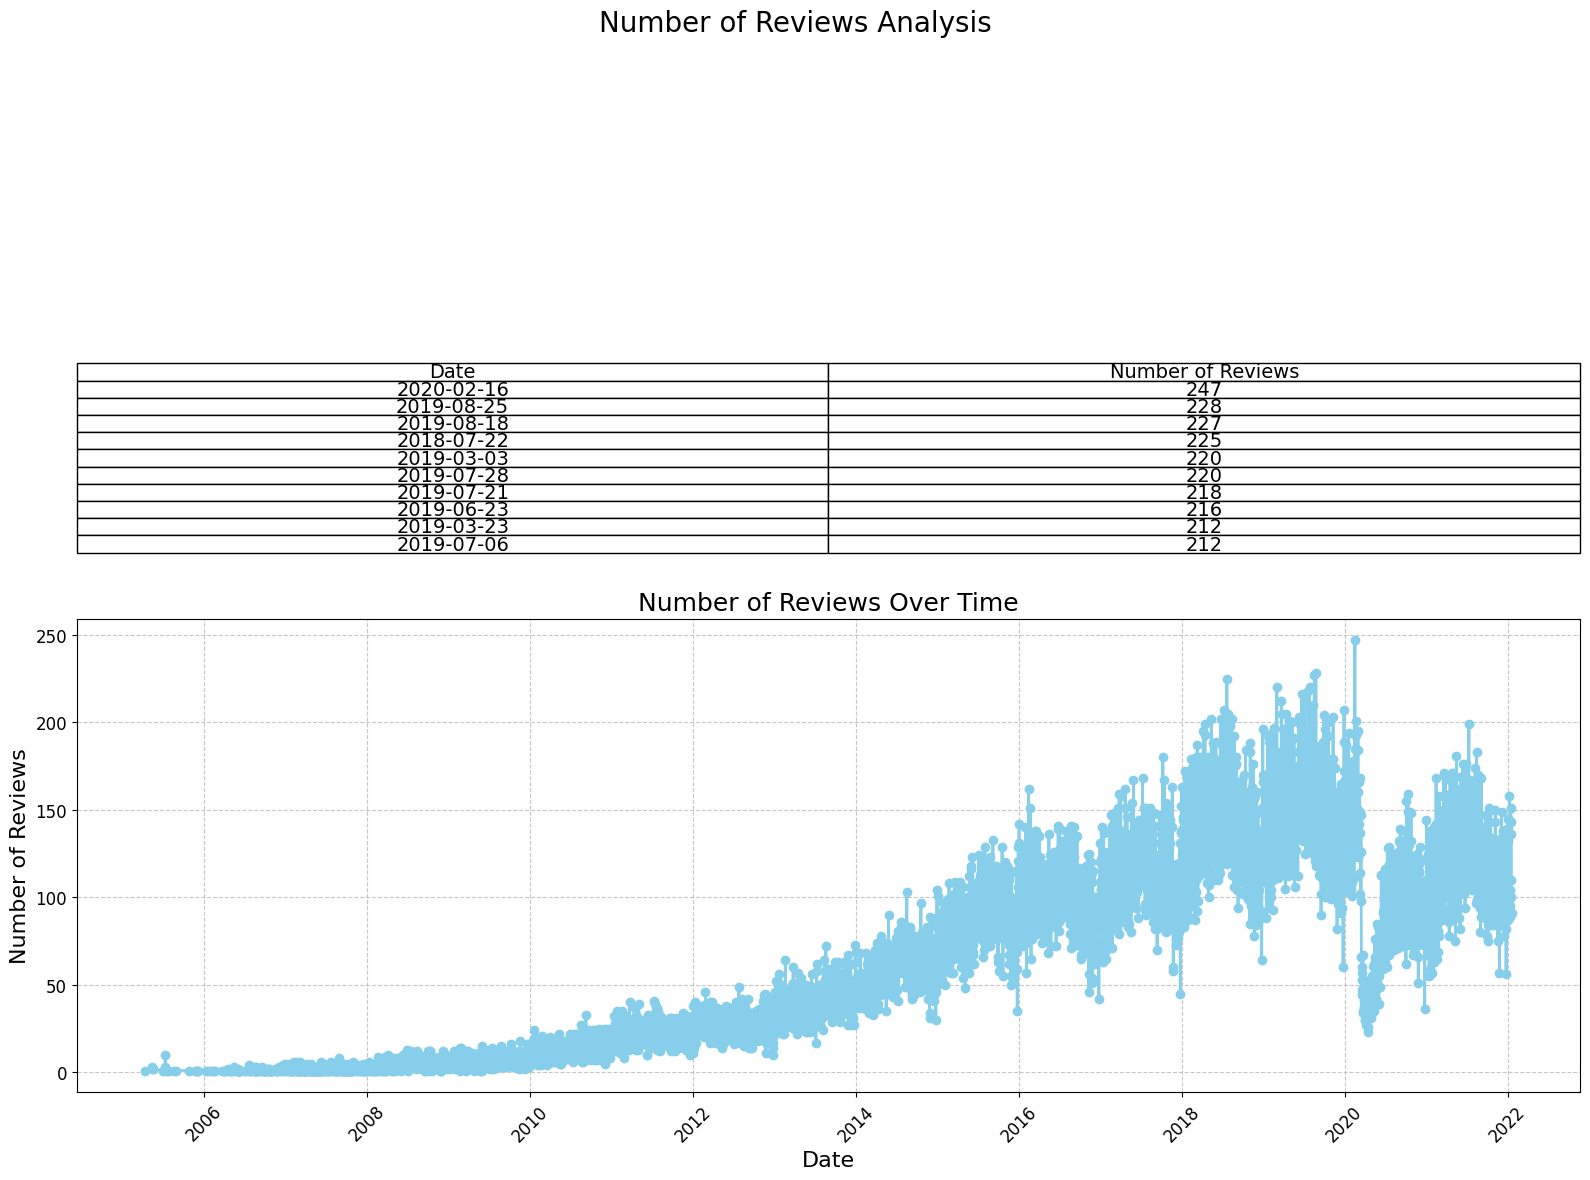

In [26]:
# Step 1: Aggregate the number of reviews per date
review_counts_by_date = df.groupby(df.date.dt.date).size()
# Get top 10 dates with the most reviews
top_10_dates = review_counts_by_date.nlargest(10).reset_index()
top_10_dates.columns = ['Date', 'Number of Reviews']
# Step 2: Plot the line chart
plt.figure(figsize=(16, 12))  # Increase figure size for better readability
# Add a title for the whole figure
plt.suptitle('Number of Reviews Analysis', fontsize=20)
# Plot the line chart
plt.subplot(2, 1, 2)  # Line chart in the second subplot
plt.plot(review_counts_by_date.index, review_counts_by_date.values, marker='o', color='skyblue', linestyle='-', linewidth=2)
# Add labels and title for the line chart
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Reviews', fontsize=16)
plt.title('Number of Reviews Over Time', fontsize=18)
# Customize ticks and grid
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels and adjust font size
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# Step 3: Add the table
plt.subplot(2, 1, 1)  # Table in the first subplot
plt.axis('off')  # Turn off the axis
table = plt.table(cellText=top_10_dates.values, colLabels=top_10_dates.columns, cellLoc='center', loc='center', bbox=[0, 0.05, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(14)  # Increase font size for better readability
table.scale(1.4, 1.4)  # Scale the table for better readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the suptitle
plt.show()

Top 10 Categories:
                       Count  count
0                Restaurants  34987
1                       Food  20419
2                   Shopping  20186
3              Home Services  13322
4              Beauty & Spas  12263
5           Health & Medical  11046
6             Local Services  10138
7                 Automotive   9879
8                  Nightlife   8379
9  Event Planning & Services   8173


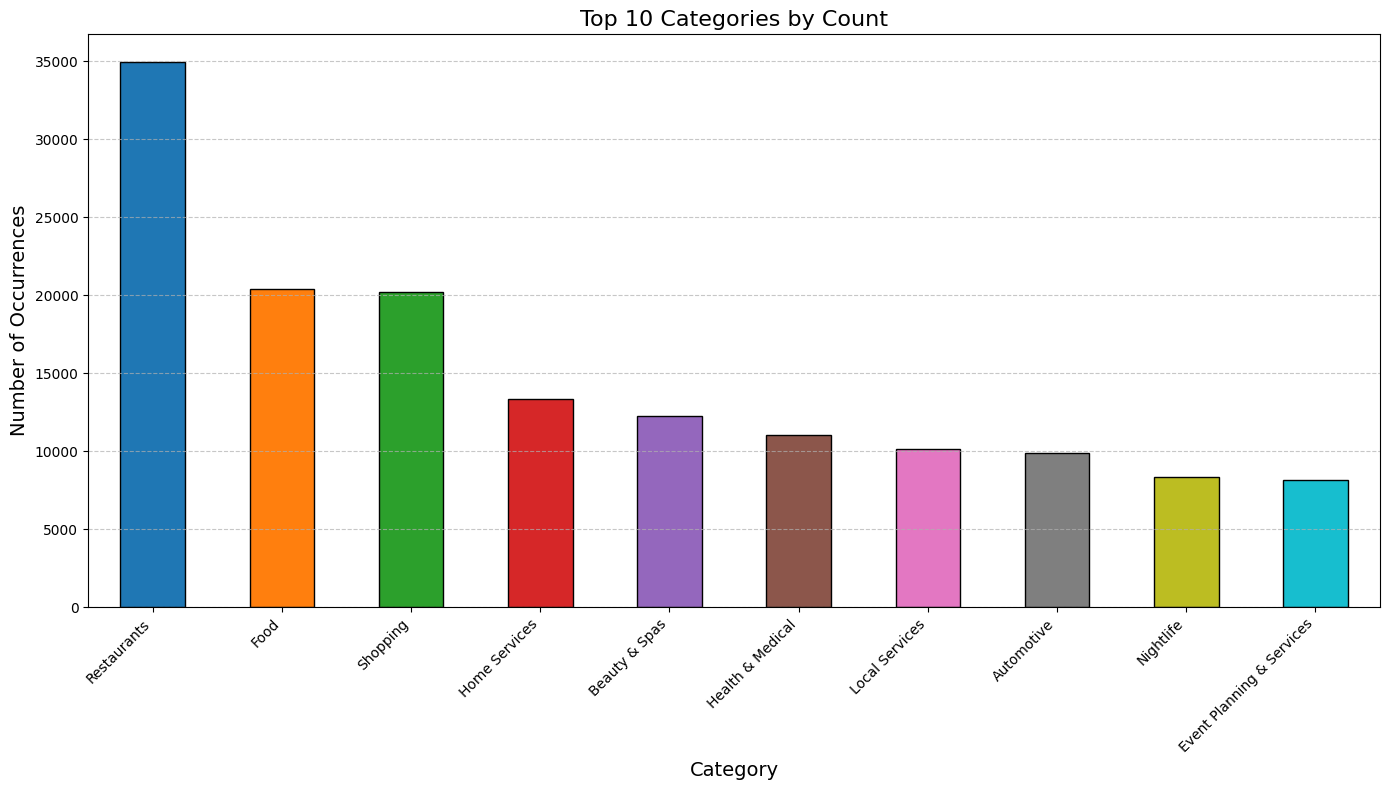

In [37]:
# Step 1: Count occurrences of each category
category_counts = df_explode['categories'].value_counts()
# Step 2: Get the top 10 most common categories
top_10_categories = category_counts.head(10)
# Step 3: Print the top 10 categories in a formatted way
print("Top 10 Categories:")
print(top_10_categories.to_frame().reset_index().rename(columns={'index': 'Category', 'categories': 'Count'}))
# Step 4: Plot the top 10 categories with enhanced styling
plt.figure(figsize=(14, 8))
colors = plt.cm.tab10(range(10))  # Use a colormap for distinct colors
top_10_categories.plot(kind='bar', color=colors, edgecolor='black')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.title('Top 10 Categories', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()